# Импорт библиотек

In [69]:
import warnings
import time
import missingno as msno
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Tuple
from scipy.stats import ttest_rel

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (KFold,
                                     StratifiedKFold,
                                     train_test_split,
                                     cross_val_score)

warnings.simplefilter("ignore")
%matplotlib inline

# Функции для проекта

## Функции для модели и подготовки данных

In [2]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model


def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

            
def prepare_data(X, categorical, to_drop=[]):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed


def _label_encoder(X, categorical = None):
    for feature in categorical:
        encoder = LabelEncoder()
        X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
    return X

        
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores, encoders = [], [], {}
    oof_preds = np.zeros(X.shape[0])
    
    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
       
        
        model = fit_catboost(x_train, y_train,
                             params, categorical,
                             x_valid, y_valid)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("==="*33)
    return estimators, encoders, oof_preds


def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          categorical:list = None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    if categorical:
        _label_encoder(X, categorical=categorical)
        
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions


def save_object(estimators, objectname):
    import pickle
    # Save to file in the current working directory
    _pkl = ".pkl"
    with open(f'{objectname}{_pkl}', 'wb') as file:
        pickle.dump(model, file)

def load_object(objectname):
    # Load from filename.pkl
    with open(objectname, 'rb') as file:
        pickle_model = pickle.load(file)
    
    return pickle_model
    
    
def run_validation(X: pd.DataFrame,
                   y: pd.Series,
                   estimator: object,
                   metric: callable =roc_auc_score,
                   cv_strategy=StratifiedKFold(n_splits=5),
                   categorical:list = None,
                   num_task=0):
    estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = \
        make_cross_validation(X, y, estimator, metric=roc_auc_score, cv_strategy=cv_strategy, categorical=categorical)
    save_object(estimators, f'estimators_run{num_task}')
    proba = np.zeros((len(estimators), X.shape[0]))
    for i, est in enumerate(estimators):
        proba[i, :] = est.predict_proba(X)[:, 1]
        proba_train = np.mean(proba, axis=0)
        train_score = roc_auc_score(y, proba_train)
        print(f"ROC AUC train score = {round(train_score, 3)}")
    return estimators




## Дополнительные функции и классы

In [3]:
def get_shape_df(data_key, data):
    return f'{data_key}.shape: {data.shape}'


def get_duplicated(data, key):
    return data.duplicated(subset=[key]).value_counts()


def get_unique_val_obj_col(data, nunique=False):
    """Уникальные значений в объектных признаках количесво по флагу"""
    object_feature_list = data.select_dtypes(exclude=[np.number]).columns.tolist()
    if nunique:
        return data[object_feature_list].nunique()
    
    return [f'{feature}:\n{data[feature].unique()}\n' for feature in object_feature_list]


def get_feature_names(data_key, data):
    """"""
    return f'{data_key}:\n{data.columns.tolist()}\n'


def get_cat_feature_names(data):
    cat_features = data.select_dtypes(exclude=[np.number]).columns.to_list()
    print(cat_features)
    return cat_features


def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T


def optimization_memory_usage(df: pd.DataFrame, category=True):
    """ 
    Функция оптимизации числовых значений по int[8, 16, 32, 64] по float[16, 32, 64]
    с преобразованием object -> category
    """
    start_memory_usage = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_memory_usage:.2f} MB')
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type != object: 
            col_min = df[column].min()
            col_max = df[column].max()
            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)

                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)

                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)

                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[column] = df[column].astype(np.float16)

                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)

                else:
                    df[column] = df[column].astype(np.float64)
        elif category:
            df[column] = df[column].astype('category')
        else:
            continue
            
    end_memory_usage = df.memory_usage().sum() / 1024**2
    percent_optimization  = 100 * (start_memory_usage - end_memory_usage) / start_memory_usage
    print(f'Memory usage after optimization is: {end_memory_usage:.2f} MB')
    print(f'Decreased by {percent_optimization:.1f}%')
    
    return df



## Функции генерации признаков

In [4]:
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


def set_concat_keys(data, keys=['GENDER', 'CHILDRENS', 'FAMILY_STATUS']):
    
    data = data.copy()
    data[f"{keys[0]}_{keys[1]}"] = data[keys[0]].astype(np.str_) + '|' + data[keys[1]].astype(np.str_)
    data[f"{keys[0]}_{keys[2]}"] = data[keys[0]].astype(np.str_) + '|' + data[keys[2]].astype(np.str_)
    data[f"{keys[1]}_{keys[2]}"] = data[keys[1]].astype(np.str_) + '|' + data[keys[2]].astype(np.str_)
    data[f"{keys[0]}_{keys[1]}_{keys[2]}"] = data[keys[0]].astype(np.str_) + '|' +  data[keys[1]].astype(np.str_) + '|' + data[keys[2]].astype(np.str_)
    
    return data


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Класс частотного кодирования списка признаков
    """
    def __init__(self, keys: list):
        self.keys = keys
        self.columns = []
        
        
    def fit(self, X:pd.DataFrame, y=None):
        self.columns = [(key, f'{key}_freq') for key in self.keys]
        return self

    
    def transform(self, data: pd.DataFrame)->pd.DataFrame:
        for key, key_freq in self.columns:
            fr_cod = data[key].value_counts(normalize=True)
            data[key_freq] = data[key].map(fr_cod)

        return data
    
    
class StatFeatures(BaseEstimator, TransformerMixin):
    """
    Класс статистических значений 
    """
    def __init__(self,
                 stat_key: str,
                 group_keys: list[str],
                 agg_funcs: list[str]):
        
        self.stat_key = stat_key
        self.group_keys = group_keys
        self.agg_funcs = agg_funcs
        
                 
    def fit_transform(self, data:pd.DataFrame, y=None):
        for agg_func in self.agg_funcs:
            for group_key in self.group_keys:
                agg_data = data.groupby(group_key, as_index=False).agg({self.stat_key: agg_func})\
                                        .rename(columns={self.stat_key:f'{agg_func}{self.stat_key}By_{group_key}'}) 
                data = data.merge(agg_data, on=group_key, how='left')
                data[f'{self.stat_key}_/_{agg_func}{self.stat_key}By_{group_key}'] = data[self.stat_key] / data[f'{agg_func}{self.stat_key}By_{group_key}']
                data = data.drop(f'{agg_func}{self.stat_key}By_{group_key}', axis=1)

        return data
    
    
class NumFracEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, key: str):
        self.key = key
        
      
    def fit_transform(self, data: pd.DataFrame)->pd.DataFrame:
        data[f'{self.key}_int'] = data[self.key]//1
        data[f'{self.key}_frac'] = data[self.key]%1
        data[f'{self.key}_log'] = np.log2(data[self.key])

        return data
    

## Функции создание 'predict', сохранения и создания сабмита

In [5]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

# Обзор задачи

**Для построения модели в данном соревновании, сначала нужно будет собрать выборку для обучения модели.**

Формат соревнования очень похож на то, как в промышленности Data Scinetist'ы строят алгоритмы:
>сначала нужно провести анализ данных

>собрать выборку 

>и после этого строить модели. 

<b>В соревновании представлены 4 типы источника данных, которые могут быть интерпретированы как таблицы в базе данных. 
    
    Некоторые источники данных уже готовы для моделирования, представлены в агрерированном виде.
    Другие источники данных требуется представить в удобном для модели виде.

<b>Описание источников данных:</b>
<ul>
<li>train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
<li>test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
<li>bki.csv - данные БКИ о предыдущих кредитах клиента;
<li>client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
<li>payments.csv - история платежей клиента;
<li>applications_history.csv - история предыдущих заявок клиента.
</ul>

## Предположение по генирации признаков

### client_profile.csv:

Признаки датасета:
    
    ['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']    

1. Выделение средних и медианных значений, для категорий выделение количества  "всех" признаков в групировке по целевой переменной

2. Вариативная конкатенация признаков:
>['GENDER', 'FAMILY_STATUS', 'CHILDRENS']

((0, 1),(0, 2), (1, 2), (0, 1, 2))

3. Отношение признака 'TOTAL_SALARY' к созданой средней, медианны зарплаты в групировке по целевой переменной
    'TOTAL_SALARY'/mean('TOTAL_SALARY')byTARGET
4. Отношение признака 'TOTAL_SALARY' к 'AMOUNT_CREDIT'
5. Отношение признака 'TOTAL_SALARY' к 'AMOUNT_ANNUITY'
6. Отношение признака 'TOTAL_SALARY' к 'FAMILY_SIZE'

7. 'AGE' - подумать о переводе в года и разделение на группы больше меньше [50-70] подобрать порог

8. Проверка скорингов по групировке с целевой переменной

# Обзор данных

## Загрузка датасетов

In [6]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
bki_df = pd.read_csv('./data/bki.csv')
client_profile_df = pd.read_csv('./data/client_profile.csv')
payments_df = pd.read_csv('./data/payments.csv')
applications_history_df = pd.read_csv('./data/applications_history.csv')

df_dict = {'train_df': train_df, 'test_df': test_df,
           'bki_df': bki_df, 'client_profile_df': client_profile_df,
           'payments_df': payments_df, 'applications_history_df':applications_history_df}

## Имена признаков в датасетах

In [7]:
for key, df in df_dict.items():
    print(get_feature_names(key, df))
    print('---'*33)

train_df:
['APPLICATION_NUMBER', 'TARGET', 'NAME_CONTRACT_TYPE']

---------------------------------------------------------------------------------------------------
test_df:
['APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE']

---------------------------------------------------------------------------------------------------
bki_df:
['APPLICATION_NUMBER', 'BUREAU_ID', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

---------------------------------------------------------------------------------------------------
client_profile_df:
['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE

## Размерности датасетов

In [8]:
for key, df in df_dict.items():
    print(get_shape_df(key, df))
    print('---'*15)

train_df.shape: (110093, 3)
---------------------------------------------
test_df.shape: (165141, 2)
---------------------------------------------
bki_df.shape: (945234, 17)
---------------------------------------------
client_profile_df.shape: (250000, 24)
---------------------------------------------
payments_df.shape: (1023932, 8)
---------------------------------------------
applications_history_df.shape: (1670214, 26)
---------------------------------------------


## Проверка дубликатов

In [9]:
for key, value in df_dict.items():
    print(f"{key}\n"
          f"{get_duplicated(value, key='APPLICATION_NUMBER')}\n"
          f"{'---'*13}")

train_df
False    110093
dtype: int64
---------------------------------------
test_df
False    165141
dtype: int64
---------------------------------------
bki_df
True     672103
False    273131
dtype: int64
---------------------------------------
client_profile_df
False    250000
dtype: int64
---------------------------------------
payments_df
True     759206
False    264726
dtype: int64
---------------------------------------
applications_history_df
True     1331357
False     338857
dtype: int64
---------------------------------------


## Количество уникальных значений для объектных признаков в датасетах

In [11]:
for key, df in df_dict.items():
    print(key)
    print('---'*8)
    print(get_unique_val_obj_col(df, nunique=True))
    print('==='*13)

train_df
------------------------
NAME_CONTRACT_TYPE    2
dtype: int64
test_df
------------------------
NAME_CONTRACT_TYPE    2
dtype: int64
bki_df
------------------------
CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        14
dtype: int64
client_profile_df
------------------------
GENDER             3
EDUCATION_LEVEL    5
FAMILY_STATUS      6
dtype: int64
payments_df
------------------------
Series([], dtype: float64)
applications_history_df
------------------------
NAME_CONTRACT_TYPE       2
NAME_CONTRACT_STATUS     4
NAME_PAYMENT_TYPE        4
CODE_REJECT_REASON       9
NAME_TYPE_SUITE          7
NAME_CLIENT_TYPE         4
NAME_GOODS_CATEGORY     28
NAME_PORTFOLIO           5
NAME_PRODUCT_TYPE        3
NAME_YIELD_GROUP         5
dtype: int64


## Уникальные значений для объектных признаков в датасетах

In [13]:
for key, df in df_dict.items():
    print(key)
    print('---'*8)
    print(*get_unique_val_obj_col(df))
    print(f"{'==='*33}")

train_df
------------------------
NAME_CONTRACT_TYPE:
['Cash' 'Credit Card']

test_df
------------------------
NAME_CONTRACT_TYPE:
['Cash' 'Credit Card']

bki_df
------------------------
CREDIT_ACTIVE:
['Active' 'Closed' 'Sold' 'Bad debt']
 CREDIT_CURRENCY:
['currency 1' 'currency 2' 'currency 3' 'currency 4']
 CREDIT_TYPE:
['Consumer credit' 'Credit card' 'Car loan' 'Mortgage'
 'Loan for business development' 'Microloan'
 'Loan for working capital replenishment' 'Unknown type of loan'
 'Loan for the purchase of equipment' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Real estate loan' 'Mobile operator loan'
 'Loan for purchase of shares (margin lending)']

client_profile_df
------------------------
GENDER:
['F' 'M' 'XNA']
 EDUCATION_LEVEL:
['Incomplete higher' 'Secondary / secondary special' 'Lower secondary'
 'Higher education' 'Academic degree']
 FAMILY_STATUS:
['Civil marriage' 'Married' 'Widow' 'Single / not married' 'Separated'
 'Unknown']

payments_df
--------------------

## train.csv 
- пары "заявка - целевая переменная"
>для этой выборки нужно собрать признаки и обучить модель;

In [15]:
train_df.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [17]:
train_df.describe()

,APPLICATION_NUMBER,TARGET
count,1.100930e+05,110093.000000
mean,1.235772e+08,0.080813
std,8.880939e+04,0.272550
min,1.234233e+08,0.000000
25%,1.235005e+08,0.000000
50%,1.235769e+08,0.000000
75%,1.236539e+08,0.000000
max,1.237308e+08,1.000000


In [18]:
check_missings(train_df)

Total NA-values = 0


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
Total,0,0,0
Percent,0.0,0.0,0.0
Types,int64,int64,object


## test.csv
- пары "заявки - прогнозное значение"
>для этой выборки нужно собрать признаки и построить прогнозы;

In [20]:
test_df.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [22]:
test_df.describe()

,APPLICATION_NUMBER
count,1.651410e+05
mean,1.235771e+08
std,8.875606e+04
min,1.234233e+08
25%,1.235001e+08
50%,1.235772e+08
75%,1.236541e+08
max,1.237309e+08


In [23]:
check_missings(test_df)

Total NA-values = 0


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
Total,0,0
Percent,0.0,0.0
Types,int64,object


## bki.csv 
- данные БКИ о предыдущих кредитах клиента;

In [24]:
bki_df.head(3)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0


In [25]:
bki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [26]:
bki_df.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,886797.000000,596274.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945234.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1819.607174,1018.001196,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,594.056297,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,4684.447770,715.013564,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,721.505604,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08


In [27]:
check_missings(bki_df)

Total NA-values = 2169701


,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
Total,0,0,0,0,0,0,58437,348960,618677,0,5,141751,325967,0,0,0,675904
Percent,0.0,0.0,0.0,0.0,0.0,0.0,6.182279,36.917843,65.452258,0.0,0.000529,14.996392,34.485323,0.0,0.0,0.0,71.506526
Types,int64,int64,object,object,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,object,float64,float64


<AxesSubplot:>

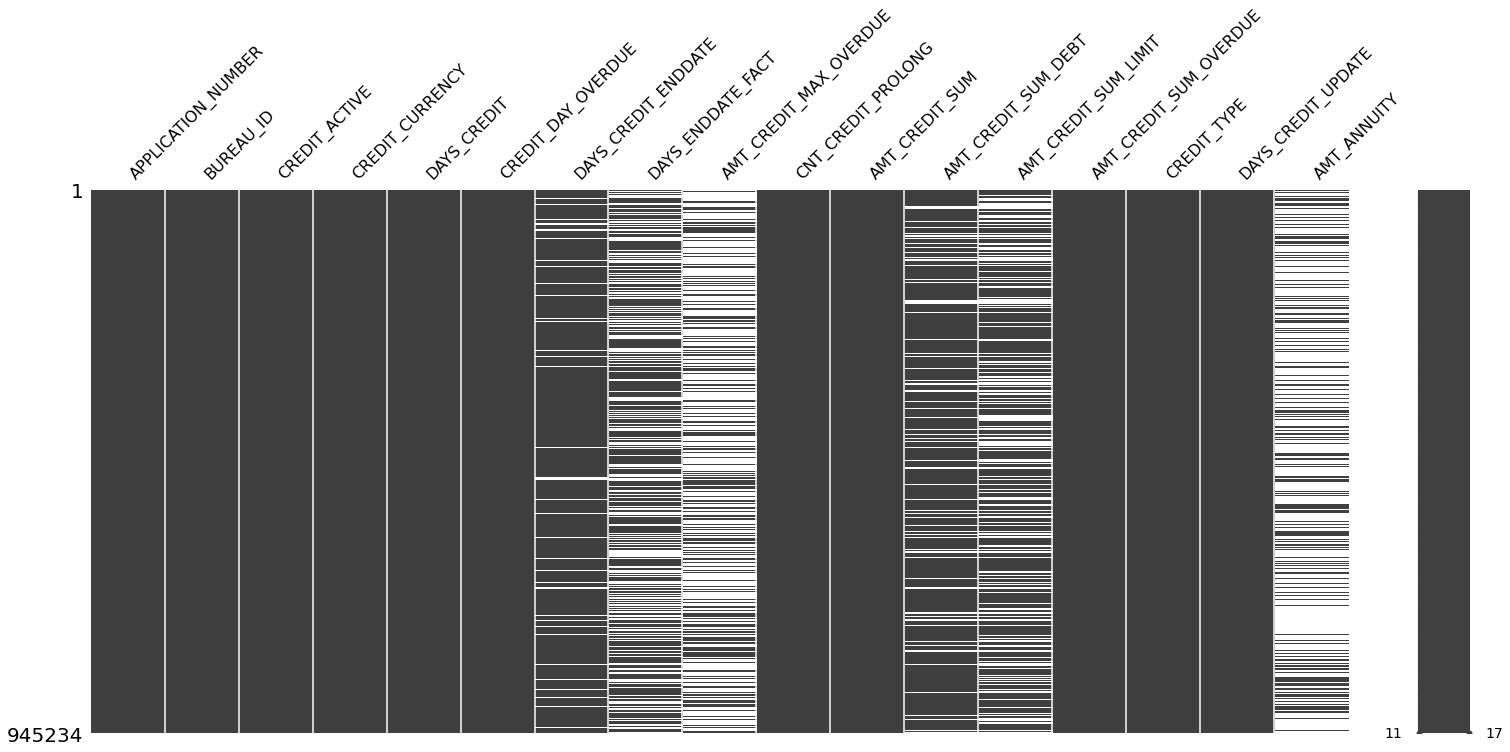

In [28]:
msno.matrix(bki_df)

## client_profile.csv
- клиентский профиль, некоторые знания, которые есть у компании о клиенте;

In [29]:
client_profile_df.head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
client_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [31]:
client_profile_df.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,...,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,...,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [32]:
check_missings(client_profile_df)

Total NA-values = 558163


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,0,0,0,0,0,11,0,0,0,0,...,2,140879,532,49538,33707,33707,33707,33707,33707,33707
Percent,0.0,0.0,0.0,0.0,0.0,0.0044,0.0,0.0,0.0,0.0,...,0.0008,56.3516,0.2128,19.8152,13.4828,13.4828,13.4828,13.4828,13.4828,13.4828
Types,int64,object,int64,float64,float64,float64,object,object,float64,int64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


<AxesSubplot:>

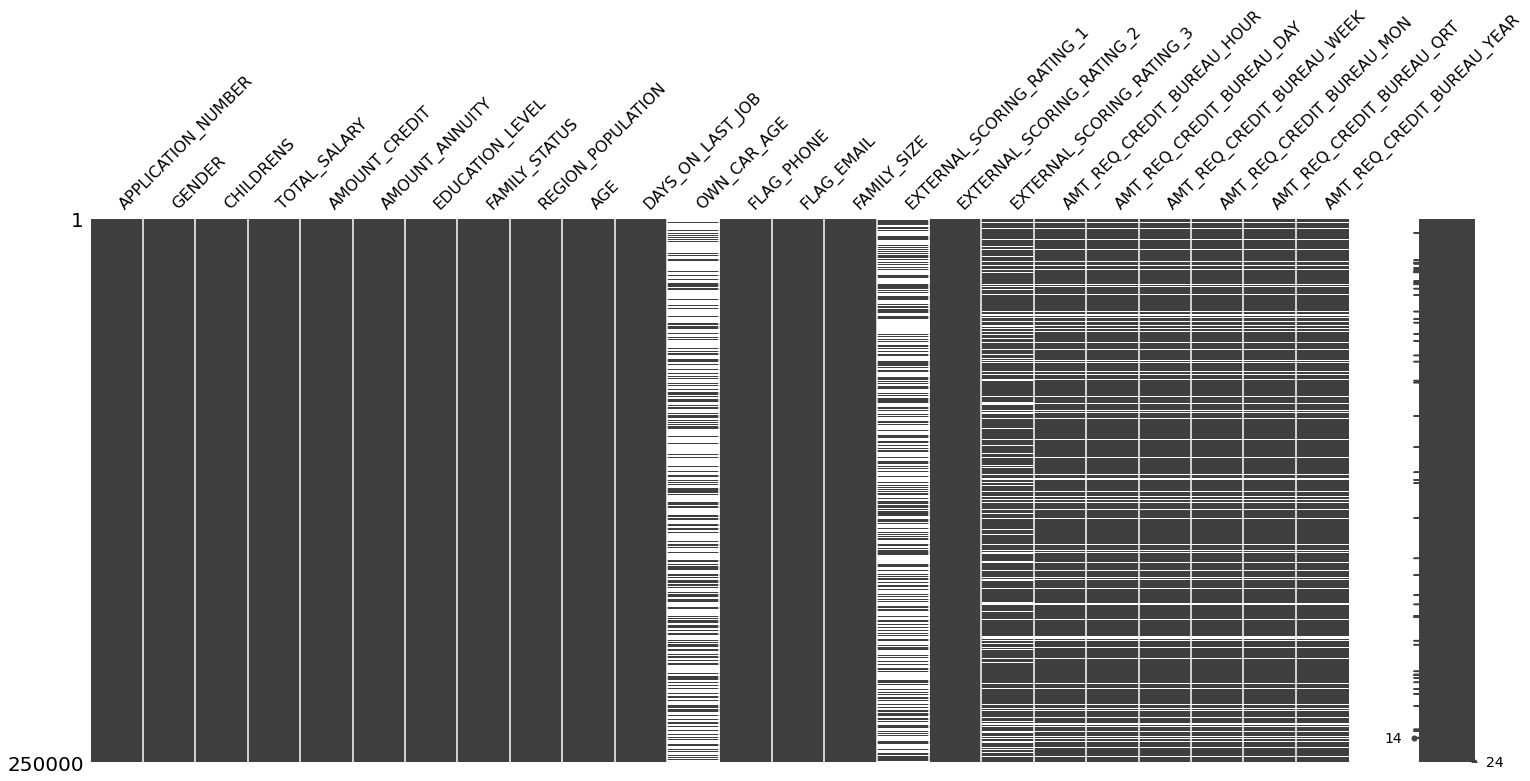

In [33]:
msno.matrix(client_profile_df)

## payments.csv
- история платежей клиента;

In [34]:
payments_df.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [35]:
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [36]:
payments_df.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,1.236018e+08,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.027412e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,1.234233e+08,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,1.235130e+08,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.236020e+08,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.236910e+08,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.237796e+08,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


In [37]:
check_missings(payments_df)

Total NA-values = 406


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Total,0,0,0,0,0,203,0,203
Percent,0.0,0.0,0.0,0.0,0.0,0.019826,0.0,0.019826
Types,int64,int64,float64,int64,float64,float64,float64,float64


<AxesSubplot:>

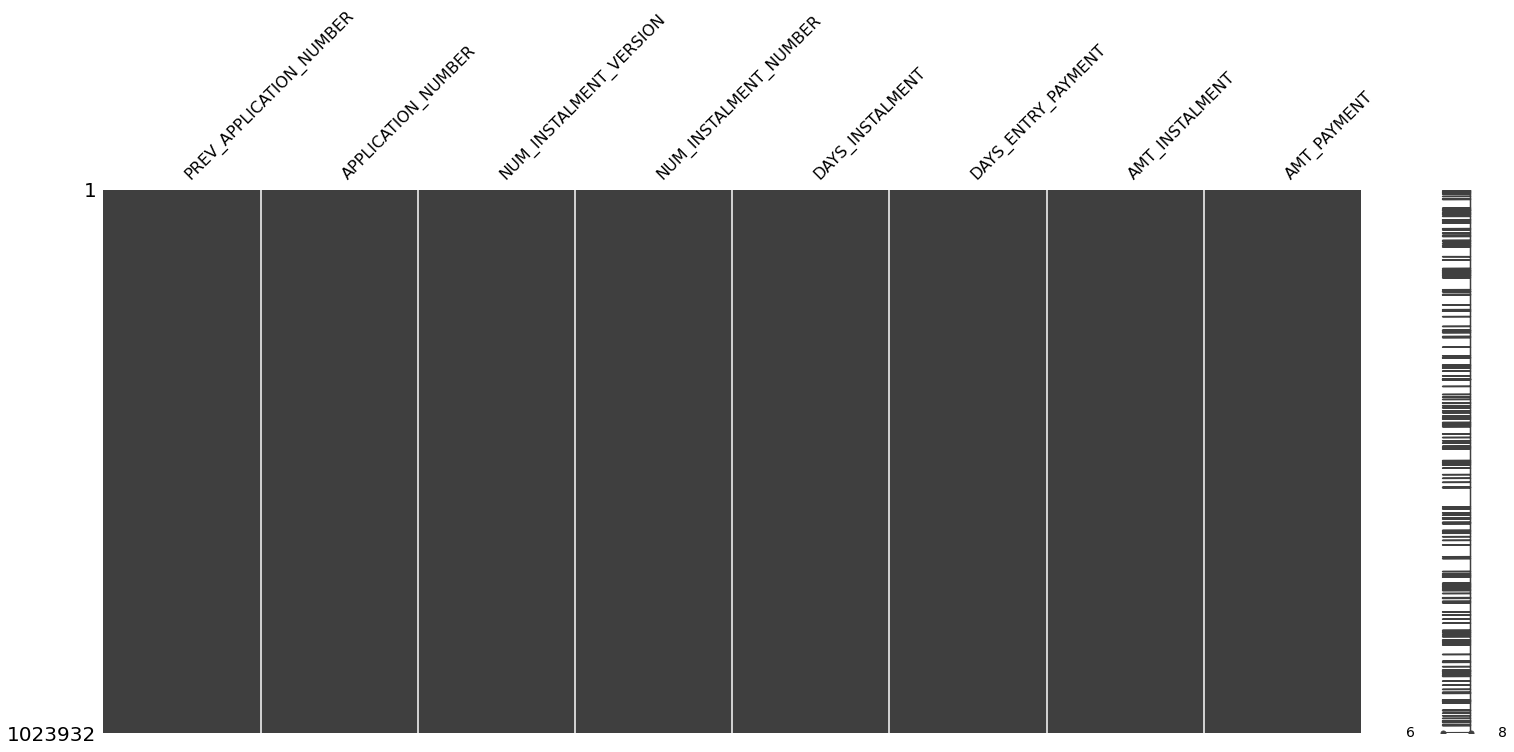

In [38]:
msno.matrix(payments_df)

## applications_history.csv
- история предыдущих заявок клиента.

In [39]:
applications_history_df.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


In [40]:
applications_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [41]:
applications_history_df.describe()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,4.919130e+07,1.236017e+08,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,3.139511e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,7.127443e+03,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,4.826822e+07,1.234233e+08,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,4.873007e+07,1.235127e+08,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,-1.000000e+00,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,4.919132e+07,1.236021e+08,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,4.965249e+07,1.236909e+08,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,8.200000e+01,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,5.011360e+07,1.237796e+08,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [42]:
check_missings(applications_history_df)

Total NA-values = 7614117


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
Total,0,0,729497,372235,0,1,895844,385515,0,0,...,0,0,372230,0,673065,673065,673065,673065,673065,673065
Percent,0.0,0.0,43.676858,22.286665,0.0,0.00006,53.63648,23.081773,0.0,0.0,...,0.0,0.0,22.286366,0.0,40.298129,40.298129,40.298129,40.298129,40.298129,40.298129
Types,int64,int64,object,float64,float64,float64,float64,float64,object,int64,...,object,int64,float64,object,float64,float64,float64,float64,float64,float64


<AxesSubplot:>

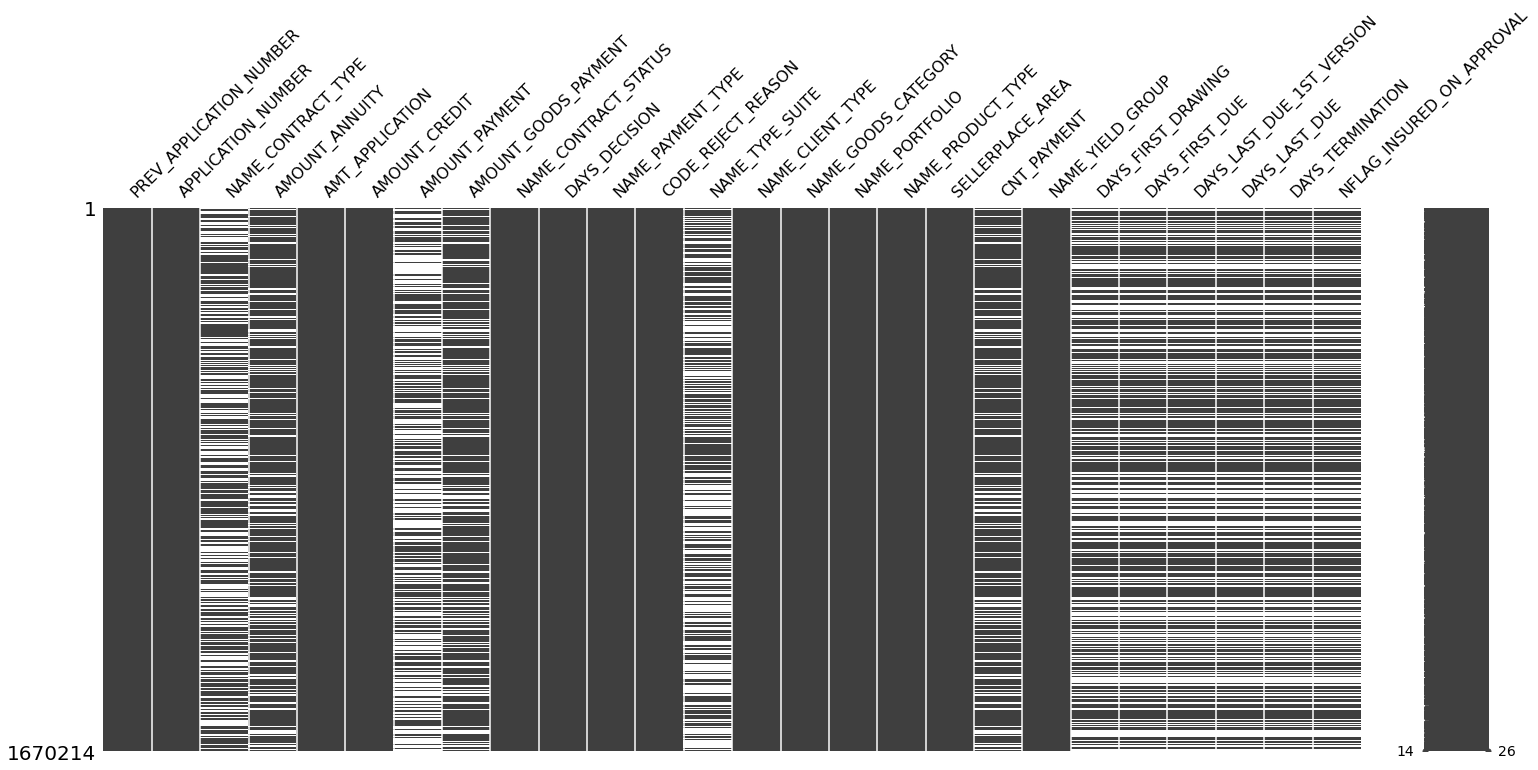

In [43]:
msno.matrix(applications_history_df)

# Параметры базовой модели

In [60]:
base_cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    "class_weights": [3, 97],
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 21
}
cb_cv = KFold(n_splits=10, random_state=21, shuffle=True)

# Объединение данных

In [45]:
train_data = pd.merge(train_df, client_profile_df, on='APPLICATION_NUMBER', how='left')
test_data = pd.merge(test_df, client_profile_df, on='APPLICATION_NUMBER', how='left')

In [46]:
target, train_data = train_data['TARGET'], train_data.drop(['TARGET'], axis=1)


In [47]:
print(train_data.shape)
train_data.head(3)

(110093, 25)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


In [48]:
print(test_data.shape)
test_data.head(3)

(165141, 25)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,...,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0
2,123428178,Credit Card,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,...,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0


## Заполнение пропусков константой

In [49]:
train_constant = train_data.copy()
test_constant = test_data.copy()

mean_imputer = SimpleImputer(strategy='constant')

train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
test_constant.iloc[:,:] = mean_imputer.fit_transform(test_constant)

train_constant.isnull().sum()

APPLICATION_NUMBER            0
NAME_CONTRACT_TYPE            0
GENDER                        0
CHILDRENS                     0
TOTAL_SALARY                  0
AMOUNT_CREDIT                 0
AMOUNT_ANNUITY                0
EDUCATION_LEVEL               0
FAMILY_STATUS                 0
REGION_POPULATION             0
AGE                           0
DAYS_ON_LAST_JOB              0
OWN_CAR_AGE                   0
FLAG_PHONE                    0
FLAG_EMAIL                    0
FAMILY_SIZE                   0
EXTERNAL_SCORING_RATING_1     0
EXTERNAL_SCORING_RATING_2     0
EXTERNAL_SCORING_RATING_3     0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
dtype: int64

In [53]:
train_constant.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,Cash,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,...,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value,missing_value
2,123526683,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,...,2.0,missing_value,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


## Заполнение пропусков наиболее встречающейся

In [51]:
train_most_frequent = train_data.copy()
test_most_frequent = test_data.copy()

mean_imputer = SimpleImputer(strategy='most_frequent')

train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)
test_most_frequent.iloc[:,:] = mean_imputer.fit_transform(test_most_frequent)

train_most_frequent.isnull().sum()

APPLICATION_NUMBER            0
NAME_CONTRACT_TYPE            0
GENDER                        0
CHILDRENS                     0
TOTAL_SALARY                  0
AMOUNT_CREDIT                 0
AMOUNT_ANNUITY                0
EDUCATION_LEVEL               0
FAMILY_STATUS                 0
REGION_POPULATION             0
AGE                           0
DAYS_ON_LAST_JOB              0
OWN_CAR_AGE                   0
FLAG_PHONE                    0
FLAG_EMAIL                    0
FAMILY_SIZE                   0
EXTERNAL_SCORING_RATING_1     0
EXTERNAL_SCORING_RATING_2     0
EXTERNAL_SCORING_RATING_3     0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
dtype: int64

In [52]:
train_most_frequent.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,Cash,F,0.0,135000.0,450000.0,9000.0,Secondary / secondary special,Married,0.035792,...,2.0,0.285593,0.285898,0.746300,0.0,0.0,0.0,0.0,0.0,0.0
2,123526683,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,...,2.0,0.285593,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


In [54]:
base_cat_features = get_cat_feature_names(train_data)

['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS']


In [56]:
train_data_lb_enc = train_data.copy()
test_data_lb_enc = test_data.copy()

train_data_lb_enc = _label_encoder(train_data_lb_enc, base_cat_features)
test_data_lb_enc = _label_encoder(test_data_lb_enc, base_cat_features)


In [57]:
print(train_data_lb_enc.shape)
train_data_lb_enc.head(3)

(110093, 25)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,1,1.0,157500.0,855000.0,25128.0,4,1,0.019101,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,0,3,NaN,NaN,NaN,NaN,5,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,0,0.0,135000.0,1006920.0,42660.0,1,1,0.026392,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


In [58]:
print(test_data_lb_enc.shape)
test_data_lb_enc.head(3)

(165141, 25)


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,0,1,0.0,117000.0,1125000.0,32895.0,4,1,0.028663,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123456549,0,0,2.0,81000.0,312768.0,17095.5,4,1,0.019689,...,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0
2,123428178,1,0,2.0,157500.0,450000.0,22500.0,4,1,0.019101,...,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0


## Базовая модель на объедененых данных:
    train.csv & client_profile.csv by APPLICATION_NUMBER
    test.csv &  client_profile.csv by APPLICATION_NUMBER
    

In [62]:
cb_estimators, cb_encoders, cb_oof_preds = catboost_cross_validation(base_cb_params,
                                                                     train_data_lb_enc,
                                                                     target,
                                                                     cb_cv,
                                                                     base_cat_features
                                                                    )

Tue Nov  2 13:24:51 2021, Cross-Validation, 110093 rows, 25 cols


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.5994079	best: 0.5994079 (0)	total: 88.5ms	remaining: 2m 56s
500:	test: 0.7254995	best: 0.7255415 (499)	total: 32.9s	remaining: 1m 38s
1000:	test: 0.7369764	best: 0.7369764 (1000)	total: 1m 4s	remaining: 1m 4s
1500:	test: 0.7449632	best: 0.7449632 (1500)	total: 1m 36s	remaining: 32.1s
1999:	test: 0.7522846	best: 0.7522846 (1999)	total: 2m 6s	remaining: 0us

bestTest = 0.7522845843
bestIteration = 1999

Fold 1, Valid score = 0.70362
0:	test: 0.6080417	best: 0.6080417 (0)	total: 67.1ms	remaining: 2m 14s
500:	test: 0.7230292	best: 0.7230292 (500)	total: 31.9s	remaining: 1m 35s
1000:	test: 0.7346287	best: 0.7346287 (1000)	total: 1m 2s	remaining: 1m 2s
1500:	test: 0.7420850	best: 0.7420850 (1500)	total: 1m 33s	remaining: 31.1s
1999:	test: 0.7490970	best: 0.7490970 (1999)	total: 2m 5s	remaining: 0us

bestTest = 0.7490969842
bestIteration = 1999

Fold 2, Valid score = 0.72574
0:	test: 0.5974454	best: 0.5974454 (0)	total: 83.1ms	remaining: 2m 46s
500:	test: 0.7226555	best: 0.7226555 

In [63]:
score_cb = roc_auc_score(target, cb_oof_preds)
print(f"Score = {round(score_cb, 5)}")

Score = 0.72037


# Predict

In [65]:
# прогноз
y_pred = np.zeros(test_data.shape[0])

estimators = cb_estimators
cv = cb_cv

for estimator in estimators:
    y_pred += estimator.predict_proba(test_data_lb_enc)[:, 1]
    
y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_data_lb_enc['APPLICATION_NUMBER'],
    "TARGET": y_pred / cv.n_splits
})

In [67]:
y_pred


y_pred.to_csv(score, index=False, encoding='utf-8')

,APPLICATION_NUMBER,TARGET
0,123724268,0.615747
1,123456549,0.917227
2,123428178,0.833533
3,123619984,0.748337
4,123671104,0.452049
...,...,...
165136,123487967,0.753761
165137,123536402,0.622840
165138,123718238,0.745465
165139,123631557,0.450024



# Создание и сохранение файла submit.
    GlukharevOlegAnatolyevich_submit{datetime.datetime.now().isoformat()}.csv

In [79]:
submit_time = datetime.datetime.now().isoformat()
submit_path = "./submits/"
submit_name = f"GlukharevOlegAnatolyevich_base_submit{submit_time}.csv"

submit_path_name = submit_path+submit_name
print('Save submit: Start')
y_pred.to_csv(submit_path_name, index=False, encoding='utf-8')
print(f'Save submit: Stop\n{"=="*13}\nsubmit_name: {submit_path_name}')

Save submit: Start
Save submit: Stop
submit_name: ./submits/GlukharevOlegAnatolyevich_base_submit2021-11-02T15:01:58.124204.csv


# Kaggle API

In [80]:
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f {submit_path_name} -m {round(score_cb, 5)}

/bin/bash: строка 1: kaggle: команда не найдена
